In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.switch_backend('agg')

#rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.rdMolDescriptors import CalcTPSA

## 데이터 불러오기

X : fingerprint, Y : logP

In [3]:
def read_data(filename):
    f = open(filename + '.smiles', 'r')
    contents = f.readlines()

    smiles = []
    labels = []
    for i in contents:
        smi = i.split()[0]
        label = int(i.split()[2].strip())

        smiles.append(smi)
        labels.append(label)

    num_total = len(smiles)
    rand_int = np.random.randint(num_total, size=(num_total,))
    
    return np.asarray(smiles)[rand_int], np.asarray(labels)[rand_int]

def read_ZINC(num_mol):
    f = open('./data/ZINC.smiles', 'r')
    contents = f.readlines()

    smi = []
    fps = []
    logP = []
    tpsa = []
    for i in range(num_mol):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        fp = AllChem.GetMorganFingerprintAsBitVect(m,2)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp,arr)
        fps.append(arr)
        logP.append(MolLogP(m))
        tpsa.append(CalcTPSA(m))

    fps = np.asarray(fps)
    logP = np.asarray(logP)
    tpsa = np.asarray(tpsa)

    return fps, logP, tpsa


In [4]:
fps_total, logP_total, tpsa_total = read_ZINC(60000)

In [5]:
num_train = 40000
num_validation = 10000
num_test = 10000

#train set
fps_train = fps_total[0:num_train]
logP_train = logP_total[0:num_train]

#val_set
fps_validation = fps_total[num_train:(num_train+num_validation)]
logP_validation = logP_total[num_train:(num_train+num_validation)]

#test_set
fps_test = fps_total[(num_train+num_validation):]
logP_test = logP_total[(num_train+num_validation):]

## 신경망 설계

### Place holder

In [6]:
X = tf.placeholder(tf.float64, shape=[None, 2048])
Y = tf.placeholder(tf.float64, shape=[None, ])

### layer

In [8]:
h1 = tf.layers.dense(X, units=512, use_bias=True, activation=tf.nn.relu)
h2 = tf.layers.dense(h1, units=512, use_bias=True, activation=tf.nn.tanh)
Y_pred = tf.layers.dense(h2, units=1, use_bias=True)
Y_pred = tf.layers.flatten(Y_pred)

### 오차함수

In [9]:
loss = tf.reduce_mean( (Y_pred - Y)**2 ) 

### 최적화

In [10]:
lr = tf.Variable(0.0, trainable = False)  # learning rate
opt = tf.train.AdamOptimizer(lr).minimize(loss)

### Session

In [11]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

## Train

In [13]:
#hyper parameter
batch_size = 100
epoch_size = 100
decay_rate = 0.95
batch_train = int(num_train/batch_size)
batch_validation = int(num_validation/batch_size)
batch_test = int(num_test/batch_size)

init_lr = 0.001

In [14]:
for t in range(epoch_size):

    pred_train = []
    sess.run(tf.assign( lr, init_lr*( decay_rate**t ) ))
    for i in range(batch_train):
        X_batch = fps_train[i*batch_size:(i+1)*batch_size]
        Y_batch = logP_train[i*batch_size:(i+1)*batch_size]
        _opt, _Y, _loss = sess.run([opt, Y_pred, loss], feed_dict = {X : X_batch, Y : Y_batch})
        pred_train.append(_Y.flatten())
        #print("Epoch :", t, "\t batch:", i, "Loss :", _loss, "\t Training")
    pred_train = np.concatenate(pred_train, axis=0)
    error = (logP_train-pred_train)
    mae = np.mean(np.abs(error))
    rmse = np.sqrt(np.mean(error**2))
    stdv = np.std(error)

    print ("MSE :", mae, "RMSE :", rmse, "Std :", stdv, "\t Training, \t Epoch :", t)

    pred_validation = []
    for i in range(batch_validation):
        X_batch = fps_validation[i*batch_size:(i+1)*batch_size]
        Y_batch = logP_validation[i*batch_size:(i+1)*batch_size]
        _Y, _loss = sess.run([Y_pred, loss], feed_dict = {X : X_batch, Y : Y_batch})
        #print("Epoch :", t, "\t batch:", i, "Loss :", _loss, "\t validation")
        pred_validation.append(_Y.flatten())

    pred_validation = np.concatenate(pred_validation, axis=0)
    error = (logP_validation-pred_validation)
    mae = np.mean(np.abs(error))
    rmse = np.sqrt(np.mean(error**2))
    stdv = np.std(error)

    print ("MSE :", mae, "RMSE :", rmse, "Std :", stdv, "\t Validation, \t Epoch :", t)

MSE : 1.0551701340029607 RMSE : 1.3230715316649728 Std : 1.3230134625070207 	 Training, 	 Epoch : 0
MSE : 1.0694329129562161 RMSE : 1.3441328432604895 Std : 1.3434063415863196 	 Validation, 	 Epoch : 0
MSE : 1.0527708030642302 RMSE : 1.3207739248721135 Std : 1.3207697589518153 	 Training, 	 Epoch : 1
MSE : 1.0678516890642225 RMSE : 1.3442886082712964 Std : 1.3441896814852887 	 Validation, 	 Epoch : 1
MSE : 1.0510167228699956 RMSE : 1.318758172927987 Std : 1.3187578847871868 	 Training, 	 Epoch : 2
MSE : 1.0664514302596961 RMSE : 1.3424294991112946 Std : 1.3423508917052465 	 Validation, 	 Epoch : 2
MSE : 1.0502378706328404 RMSE : 1.317897818719092 Std : 1.3178976779404932 	 Training, 	 Epoch : 3
MSE : 1.0653297739270866 RMSE : 1.3411527584138097 Std : 1.3411423955778659 	 Validation, 	 Epoch : 3
MSE : 1.0499523201492833 RMSE : 1.3176253725191625 Std : 1.31762509688643 	 Training, 	 Epoch : 4
MSE : 1.0630041686016096 RMSE : 1.3401893769497257 Std : 1.3398869931083324 	 Validation, 	 Epoc

MSE : 1.070595424482622 RMSE : 1.3443506387219393 Std : 1.3424973509256792 	 Validation, 	 Epoch : 40
MSE : 1.0503252255985918 RMSE : 1.318300260148268 Std : 1.3183002597410889 	 Training, 	 Epoch : 41
MSE : 1.0705502990379006 RMSE : 1.3442960237309654 Std : 1.3424355155182954 	 Validation, 	 Epoch : 41
MSE : 1.0503561435154398 RMSE : 1.3183291654112892 Std : 1.3183291650901834 	 Training, 	 Epoch : 42
MSE : 1.070733575879143 RMSE : 1.3444401374561579 Std : 1.3424643972620267 	 Validation, 	 Epoch : 42
MSE : 1.050324716156808 RMSE : 1.318310598838994 Std : 1.3183105958536994 	 Training, 	 Epoch : 43
MSE : 1.0710342099917323 RMSE : 1.3446717352425206 Std : 1.342533455366603 	 Validation, 	 Epoch : 43
MSE : 1.0503571558414753 RMSE : 1.318346566282129 Std : 1.3183465621179093 	 Training, 	 Epoch : 44
MSE : 1.0711687753535881 RMSE : 1.3447482173526015 Std : 1.3425015130330549 	 Validation, 	 Epoch : 44
MSE : 1.0503025889494613 RMSE : 1.3183108354043316 Std : 1.3183108329317723 	 Training, 

MSE : 1.0502531548737248 RMSE : 1.3183114272030378 Std : 1.318311422692183 	 Training, 	 Epoch : 81
MSE : 1.070592027353002 RMSE : 1.344035809357301 Std : 1.3420737311140867 	 Validation, 	 Epoch : 81
MSE : 1.0502550373529889 RMSE : 1.3183119029925185 Std : 1.3183118989488145 	 Training, 	 Epoch : 82
MSE : 1.0705976879293324 RMSE : 1.3440414278480421 Std : 1.3420736653890415 	 Validation, 	 Epoch : 82
MSE : 1.0502573728740903 RMSE : 1.3183132585381339 Std : 1.3183132550150602 	 Training, 	 Epoch : 83
MSE : 1.0706012049289106 RMSE : 1.3440425810151229 Std : 1.342071310000767 	 Validation, 	 Epoch : 83
MSE : 1.050258359420708 RMSE : 1.3183138151939953 Std : 1.3183138120252187 	 Training, 	 Epoch : 84
MSE : 1.070594779253256 RMSE : 1.344037255139512 Std : 1.3420640192509243 	 Validation, 	 Epoch : 84
MSE : 1.0502618185529504 RMSE : 1.3183143436196847 Std : 1.318314340768154 	 Training, 	 Epoch : 85
MSE : 1.0705931325879567 RMSE : 1.3440342637979374 Std : 1.342060242867654 	 Validation, 	 

## Test

In [15]:
pred_test = []
for i in range(batch_test):
    X_batch = fps_test[i*batch_size:(i+1)*batch_size]
    Y_batch = logP_test[i*batch_size:(i+1)*batch_size]
    _Y, _loss = sess.run([Y_pred, loss], feed_dict = {X : X_batch, Y : Y_batch})
    #print("Epoch :", t, "\t batch:", i, "Loss :", _loss, "\t validation")
    pred_test.append(_Y.flatten())

pred_test = np.concatenate(pred_test, axis=0)
error = (logP_test-pred_test)
mae = np.mean(np.abs(error))
rmse = np.sqrt(np.mean(error**2))
stdv = np.std(error)

print ("MSE :", mae, "RMSE :", rmse, "Std :", stdv, "\t Test")

MSE : 1.0752506260923393 RMSE : 1.3604792021689789 Std : 1.3585622846554917 	 Test


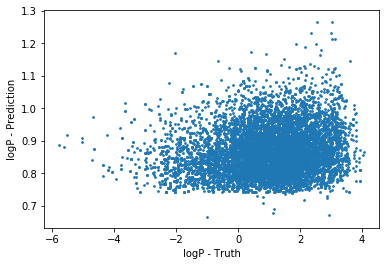

In [16]:
plt.figure()
plt.scatter(logP_test, pred_test, s=3)
plt.xlabel('logP - Truth')
plt.ylabel('logP - Prediction')
plt.savefig('logP_mlp.png')